In [1]:
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

from ray import tune
from ray.tune.schedulers import ASHAScheduler

from amlvae.models.VAE import VAE
from sklearn.metrics import r2_score 
from matplotlib import pyplot as plt

import os
import tempfile

from ray.tune import Checkpoint
import pandas as pd 

from scipy.stats import spearmanr
import seaborn as sbn

from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

import umap 
import math

from sklearn.decomposition import PCA

from amlvae.train.Trainer import Trainer

In [10]:
trainer = Trainer(
    root='/home/teddy/local/AMLVAE/data/',
    checkpoint=False,
    epochs=1000,
    verbose=True, 
    patience=100
)

In [39]:
config = {
        'n_hidden'   : 2048,
        'n_layers'   : 2,
        'n_latent'   : 16,
        'norm'       : 'none',
        'variational': True,
        'anneal'     : False,
        'aggresive_updates': False,
        'dropout'    : 0.2,
        'nonlin'     : 'elu',
        'lr'         : 1e-4,
        'alpha'      : 0.1,
        'l2'         : 0,
        'beta'       : 1.0,
        'batch_size' : 256, 
    }

model = trainer(config)

In [40]:
torch.save(model, '../output/var_preproc5000_TPM_5-1-25/vae.pt')

In [41]:
with torch.no_grad(): xhat = model.predict(trainer.X_test.to('cuda')).cpu()
r2_test = r2_score(trainer.X_test.cpu().numpy(), xhat.cpu().numpy(), multioutput='variance_weighted')
mse_test = F.mse_loss(trainer.X_test, xhat).item()

with torch.no_grad(): xhat = model.predict(trainer.X_train.to('cuda')).cpu()
r2_train = r2_score(trainer.X_train.cpu().numpy(), xhat.cpu().numpy(), multioutput='variance_weighted')
mse_train = F.mse_loss(trainer.X_train, xhat).item()

with torch.no_grad(): xhat = model.predict(trainer.X_val.to('cuda')).cpu()
r2_val = r2_score(trainer.X_val.cpu().numpy(), xhat.cpu().numpy(), multioutput='variance_weighted')
mse_val = F.mse_loss(trainer.X_val, xhat).item()

print(f'Train R2: {r2_train:.4f}')
print(f'Validation R2: {r2_val:.4f}')
print(f'Test R2: {r2_test:.4f}')
print() 
print(f'Train MSE: {mse_train:.4f}')
print(f'Validation MSE: {mse_val:.4f}')
print(f'Test MSE: {mse_test:.4f}')

Train R2: 0.7601
Validation R2: 0.2351
Test R2: 0.6238

Train MSE: 0.2394
Validation MSE: 0.6533
Test MSE: 0.3865


In [42]:
z_test = model.encode(trainer.X_test.to('cuda'))[0].cpu()

(array([1., 2., 1., 2., 1., 2., 2., 2., 0., 3.]),
 array([-0.98132163, -0.8354497 , -0.68957782, -0.54370594, -0.397834  ,
        -0.25196213, -0.10609019,  0.03978175,  0.18565363,  0.3315255 ,
         0.47739744]),
 <BarContainer object of 10 artists>)

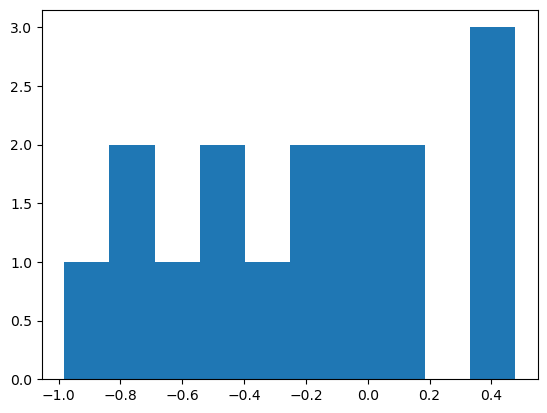

In [43]:
plt.hist(z_test.mean(0).cpu().detach().numpy())

(array([2., 0., 1., 2., 2., 3., 2., 2., 1., 1.]),
 array([0.97805744, 1.01755726, 1.05705702, 1.09655678, 1.13605654,
        1.1755563 , 1.21505618, 1.25455594, 1.2940557 , 1.33355546,
        1.37305522]),
 <BarContainer object of 10 artists>)

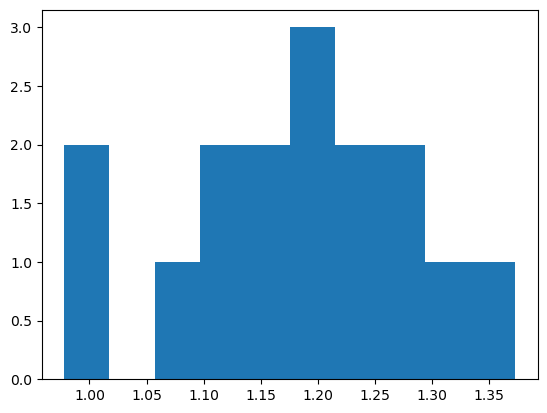

In [44]:
plt.hist(z_test.std(0).cpu().detach().numpy())

In [45]:
pca = PCA(n_components=config['n_latent'])
pc = pca.fit_transform(trainer.X_train.cpu().numpy())
xhat = pca.inverse_transform(pc) 

mse_train = (
    (xhat - trainer.X_train.cpu().numpy())**2
).mean(axis=1)
r2_train = r2_score(trainer.X_train.cpu().numpy(), xhat, multioutput='variance_weighted')

xhat = pca.inverse_transform(pca.transform(trainer.X_test.cpu().numpy()))
mse_test = (
    (xhat - trainer.X_test.cpu().numpy())**2
).mean(axis=1)
r2_test = r2_score(trainer.X_test.cpu().numpy(), xhat, multioutput='variance_weighted')

xhat = pca.inverse_transform(pca.transform(trainer.X_val.cpu().numpy()))
mse_val = (
    (xhat - trainer.X_val.cpu().numpy())**2
).mean(axis=1)
r2_val = r2_score(trainer.X_val.cpu().numpy(), xhat, multioutput='variance_weighted')

print(f'PCA Train R2: {r2_train:.4f}')
print(f'PCA Validation R2: {r2_val:.4f}')
print(f'PCA Test R2: {r2_test:.4f}')
print()

print(f'PCA MSE: {mse_train.mean():.4f}')
print(f'PCA Validation MSE: {mse_val.mean():.4f}')
print(f'PCA Test MSE: {mse_test.mean():.4f}')

PCA Train R2: 0.6662
PCA Validation R2: 0.2316
PCA Test R2: 0.6062

PCA MSE: 0.3331
PCA Validation MSE: 0.6563
PCA Test MSE: 0.4045


In [38]:
pc.mean(0)

array([ 3.8258949e-07, -9.7047092e-08,  6.1587578e-08,  5.5393826e-07,
        2.3795200e-08, -4.3577876e-07,  2.7247839e-07, -8.2116770e-08,
        1.4183806e-07,  6.1587578e-08, -2.2582113e-07, -1.2877403e-07,
        4.9456690e-07, -1.9782676e-07,  2.5404876e-07,  1.8289644e-07],
      dtype=float32)

In [164]:
pc.std(0)

array([27.855375 , 25.804913 , 19.985455 , 15.826287 , 13.709327 ,
       13.58529  , 11.827773 , 10.79464  , 10.172817 ,  9.767872 ,
        9.117149 ,  8.803549 ,  8.466574 ,  7.9325585,  7.647057 ,
        7.1606717,  6.917975 ,  6.7273636,  6.5059843,  6.1951504,
        6.120706 ,  5.886353 ,  5.7880135,  5.3973475,  5.3581805,
        5.1191306,  5.0600905,  4.725851 ,  4.67399  ,  4.545318 ,
        4.438529 ,  4.4004683], dtype=float32)